# *BEATS CT reconstruction pipeline*
[TomoPy](https://tomopy.readthedocs.io/en/latest/) reconstruction pipeline for the [BEATS beamline](https://beats-sesame.eu/) of [SESAME](https://www.sesame.org.jo/)

Created on:  23.05.2021 <br />
Last update: 07.06.2023 <br />

- By: [Gianluca Iori](https://github.com/gianthk), 2023
- Code license: MIT
- Narrative license: CC-BY-NC-SA

## Notes

### How to activate a TomoPy kernel in Jupyter:
`conda env list`

`source activate tomopy`

`python -m ipykernel install --user --name tomopy_source --display-name "conda (tomopy_source)"`

`jupyter notebook &`

---
## Configuration and imports

In [38]:
%%html
<style>
table {float:left}
</style>

In [39]:
import sys
sys.path.append('./../recon_utils/')

In [40]:
import os
import dxchange
import tomopy
import numpy as np
import h5py
import matplotlib
import matplotlib.pyplot as plt
import logging
import recon_utils as ru

In [41]:
matplotlib.rcParams['figure.dpi'] = 300
plt.style.use('ggplot')

In [42]:
logging.basicConfig(level=logging.INFO)

In [43]:
Fiij_exe = '/opt/fiji-linux64/Fiji.app/ImageJ-linux64'
Fiji_exe_stack = Fiij_exe + ' -macro FolderOpener_virtual.ijm '

In [44]:
ncore = 36 # BL-BEATS-WS01

## Load experiment data

In [114]:
work_dir_darks = "/mnt/PETRA/SED/BEATS/IH/cbs2-20230607T115907"
h5file_darks = work_dir_darks+"/cbs2-20230607T115907.h5"

In [138]:
# sample 2: tooth
work_dir = "/mnt/PETRA/SED/BEATS/IH/cbs2-20230607T115907"
h5file = work_dir+"/cbs2-20230607T115907.h5"
recon_dir = "/home/beats/Data/beats_lecture/tooth/recon/"
recon_dir_8bit = "/home/beats/Data/beats_lecture/tooth/recon_8bit/"

Read dataset portion

In [139]:
projs, flats, darks, theta = dxchange.read_aps_32id(h5file, exchange_rank=0, sino=(400, 1000, 1))

INFO:dxchange.reader:Data successfully imported: /mnt/PETRA/SED/BEATS/IH/cbs2-20230607T115907/cbs2-20230607T115907.h5
INFO:dxchange.reader:Data successfully imported: /mnt/PETRA/SED/BEATS/IH/cbs2-20230607T115907/cbs2-20230607T115907.h5
INFO:dxchange.reader:Data successfully imported: /mnt/PETRA/SED/BEATS/IH/cbs2-20230607T115907/cbs2-20230607T115907.h5
INFO:dxchange.reader:Data successfully imported: /mnt/PETRA/SED/BEATS/IH/cbs2-20230607T115907/cbs2-20230607T115907.h5


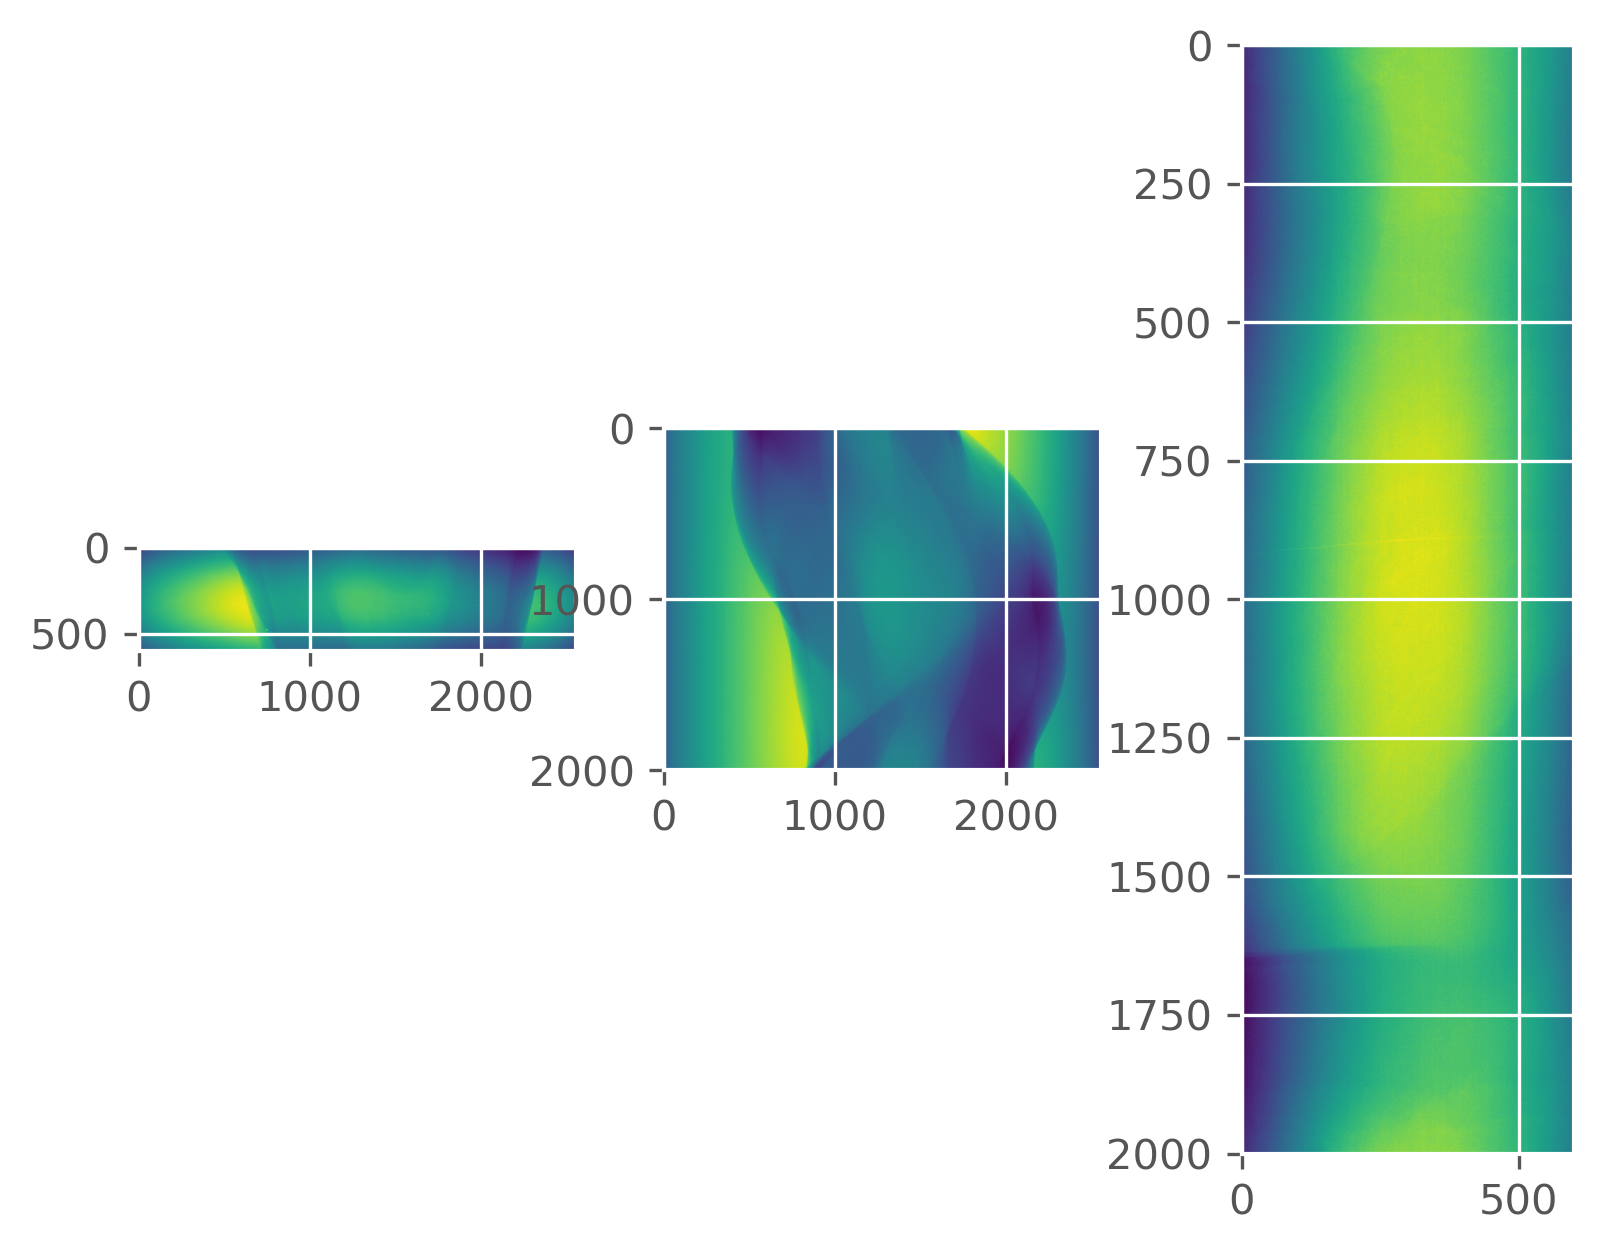

In [140]:
ru.plot_midplanes(projs)

## Flat field correction

In [141]:
projs = tomopy.normalize(projs, flats, darks, ncore=ncore)

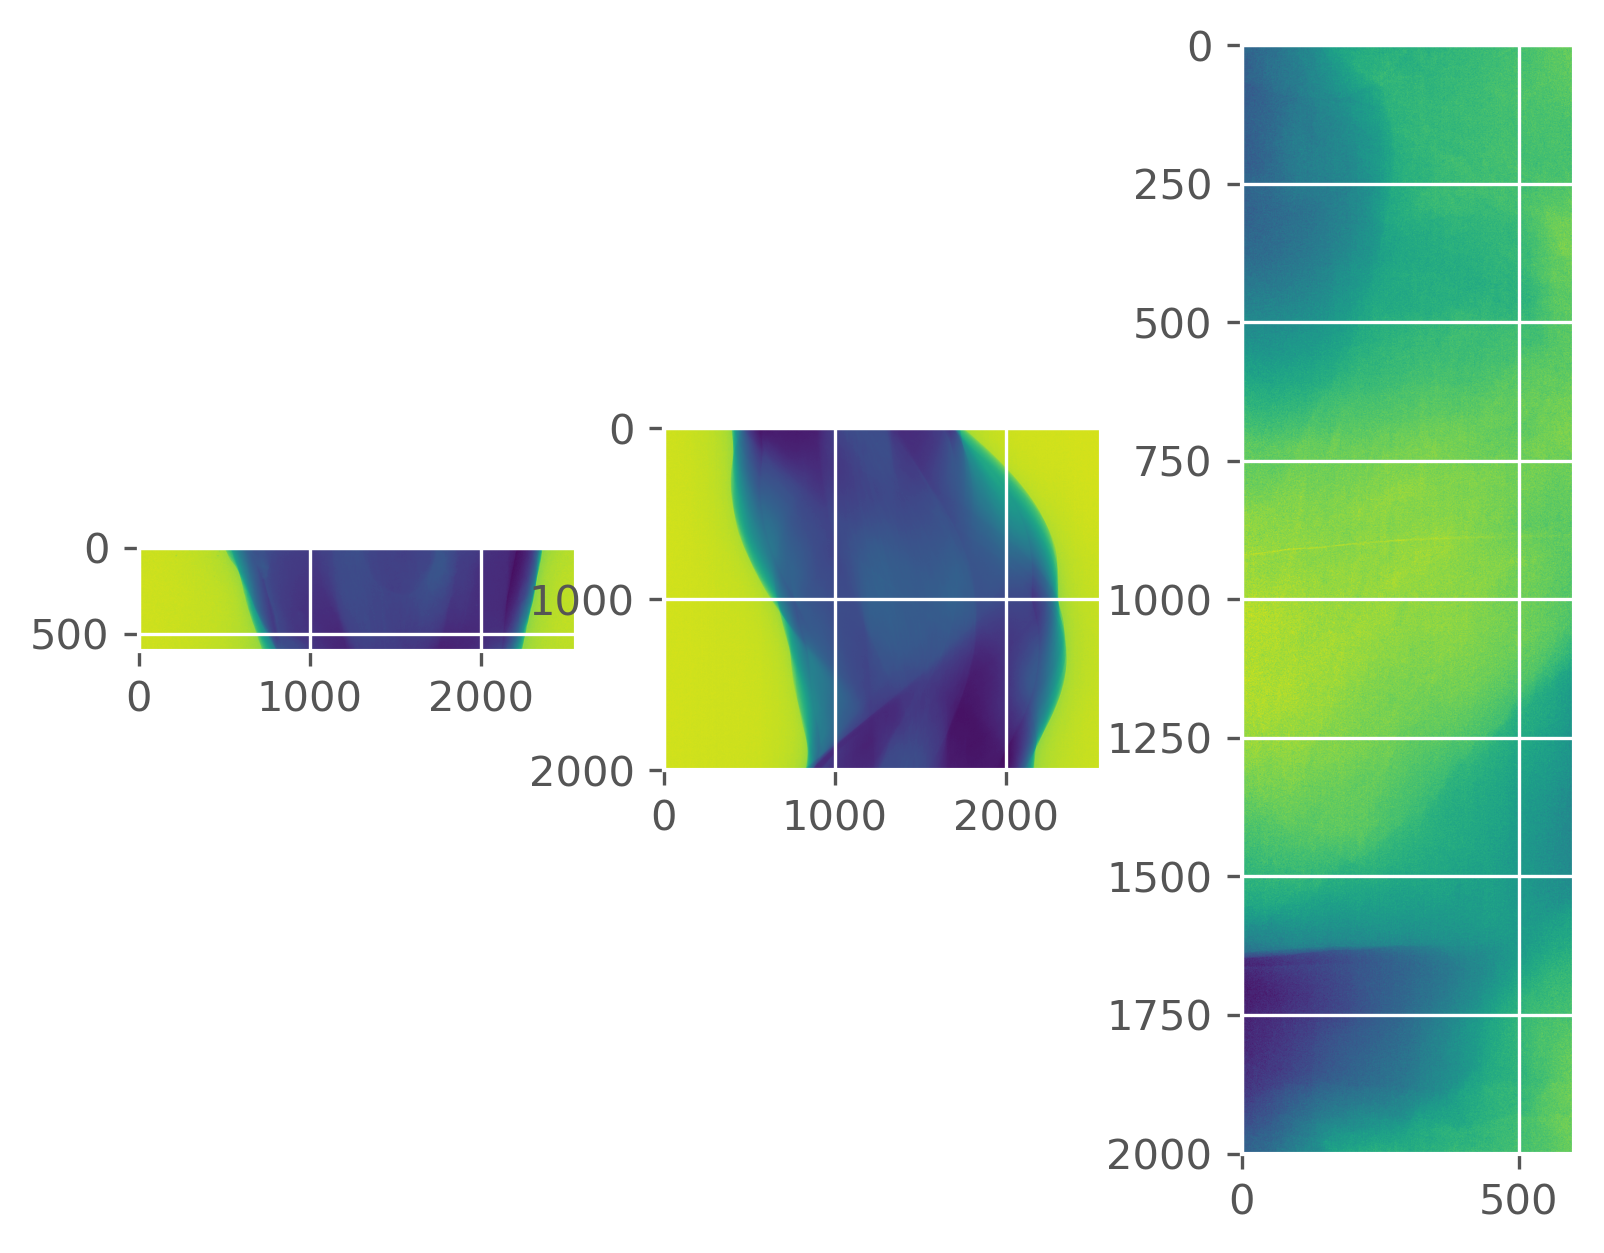

In [142]:
ru.plot_midplanes(projs)

## Log transform
Calculate $ -log(projs) $ to linearize transmission tomography data.

In [143]:
projs = tomopy.minus_log(projs, ncore=ncore)

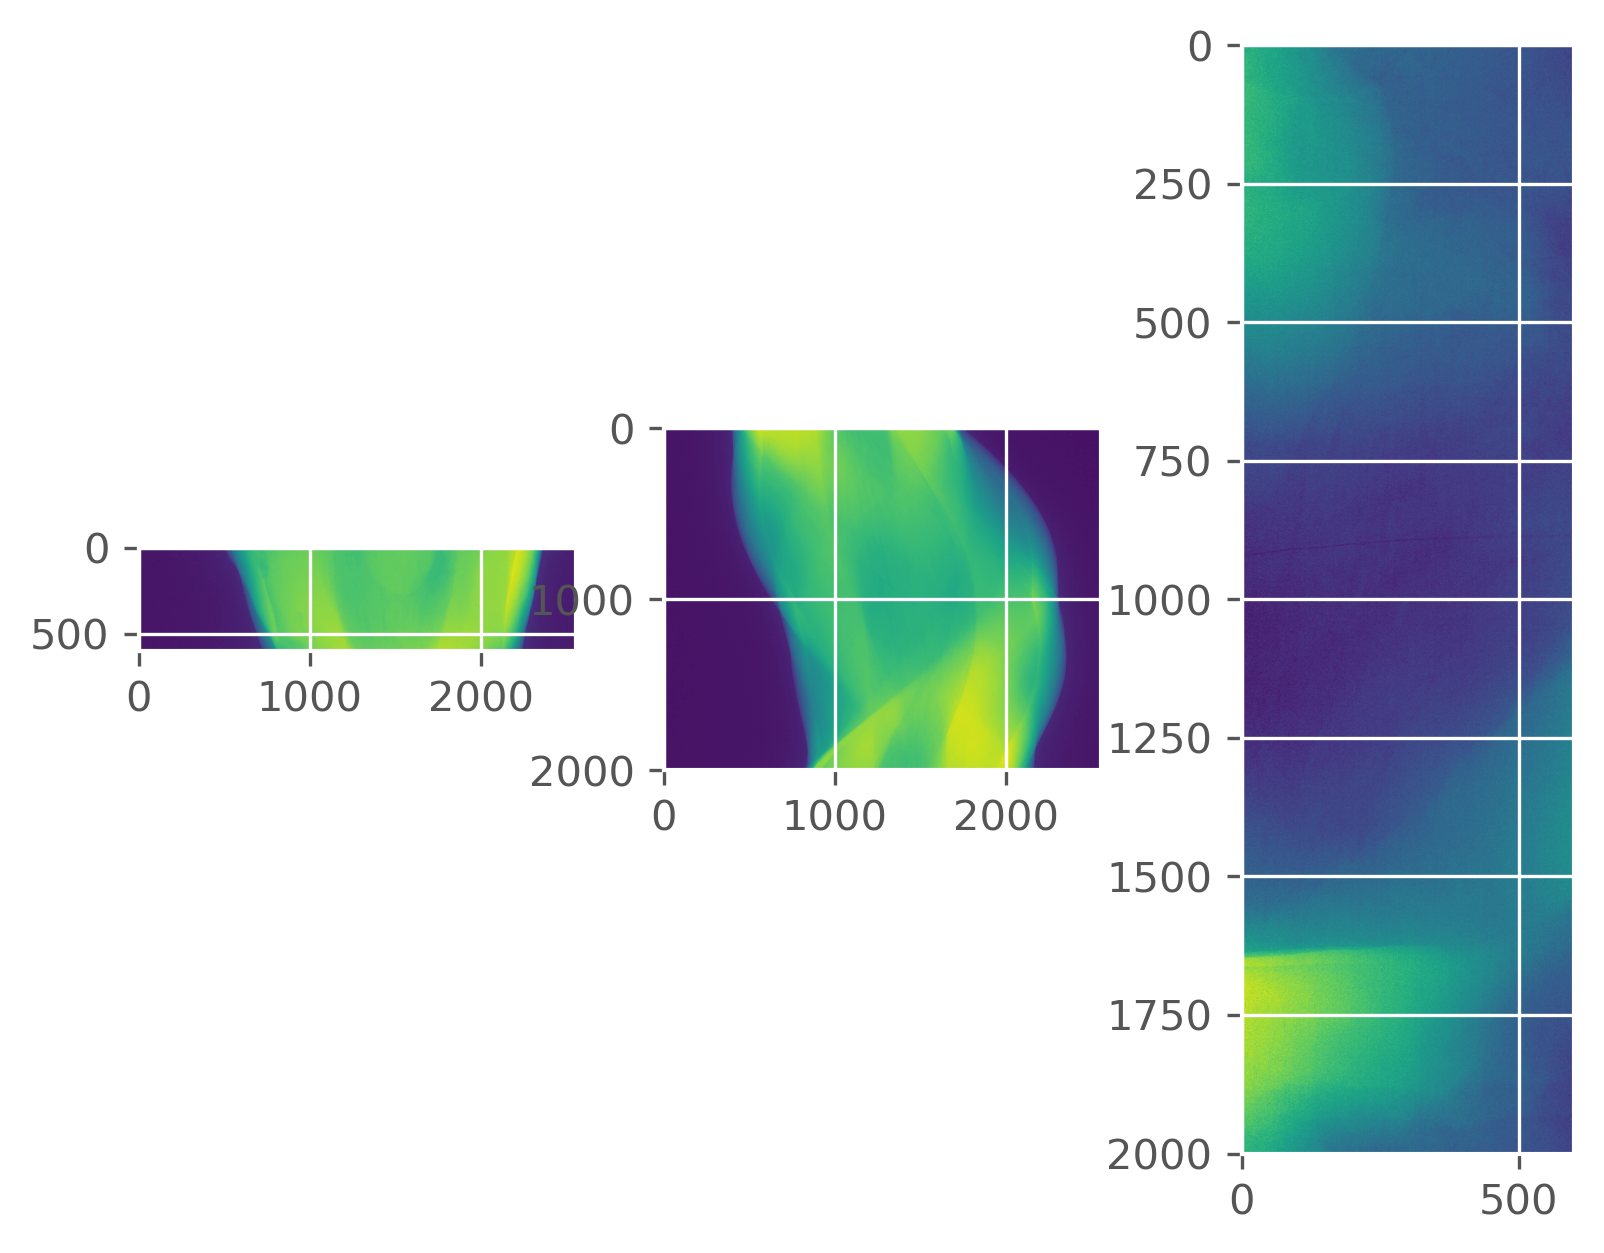

In [144]:
ru.plot_midplanes(projs)

## Center Of Rotation (COR)
### Automatic detect COR

In [122]:
COR = tomopy.find_center_vo(projs, ncore=ncore)
print(COR)

1278.5


## Reconstruction

### Reconstruct and inspect one slice

In [145]:
recon_slice = 500

In [147]:
recon = tomopy.recon(projs[:, [recon_slice], :],
                     theta,
                     center=COR,
                     algorithm='gridrec',
                     sinogram_order=False
                    )

INFO:tomopy.recon.algorithm:Reconstructing 1 slice groups with 1 master threads...


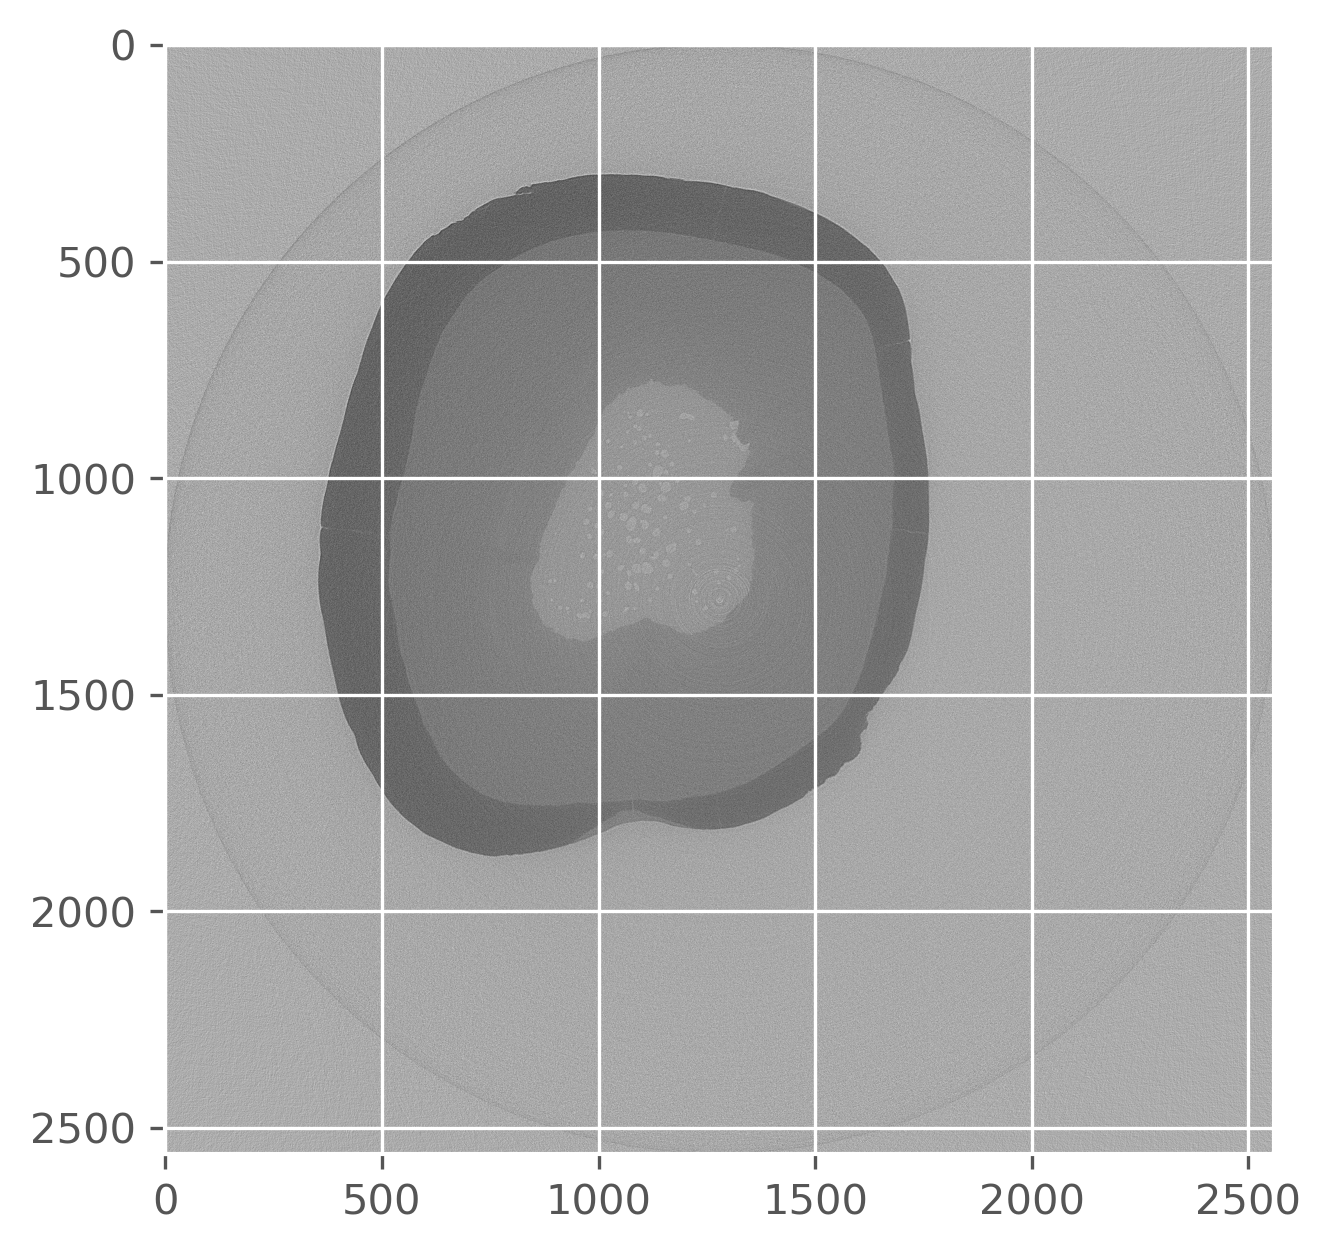

In [148]:
plt.imshow(recon.squeeze(), cmap='Greys')

### CPU reconstruction of the entire dataset
|  |  |
| :--- | :--- |
| **Algorithm**      | `gridrec` |

In [149]:
recon = tomopy.recon(projs,
                     theta,
                     center=COR,
                     algorithm='gridrec',
                     sinogram_order=False,
                     ncore=ncore)

INFO:tomopy.recon.algorithm:Reconstructing 36 slice groups with 36 master threads...


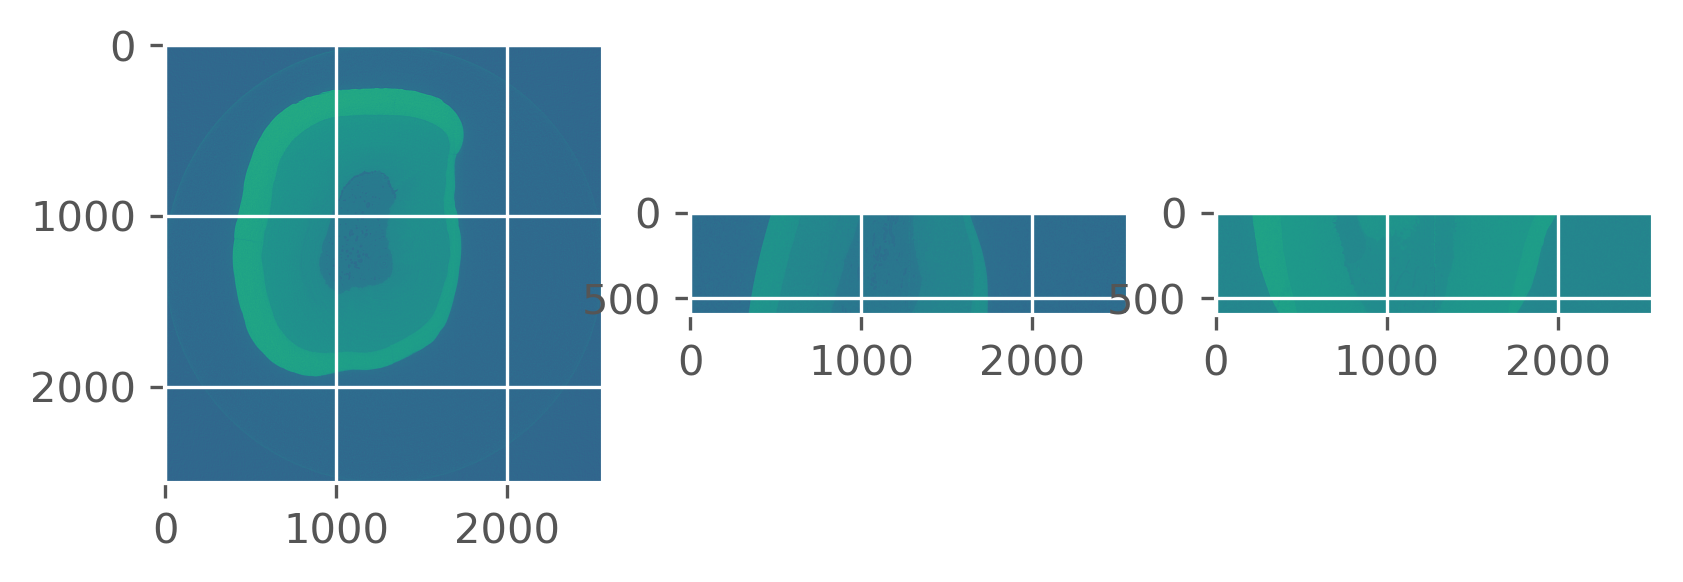

In [150]:
ru.plot_midplanes(recon)

## Post-processing

### Scale to 0-255 (`uint8`)
The uint8 GV range for output slices can cover the full float32 range or be selected based on the 3D data histogram

In [151]:
range_min = -0.0006
range_max = 0.0012

In [152]:
recon_uint8 = ru.touint(recon, 'uint8', [range_min, range_max])

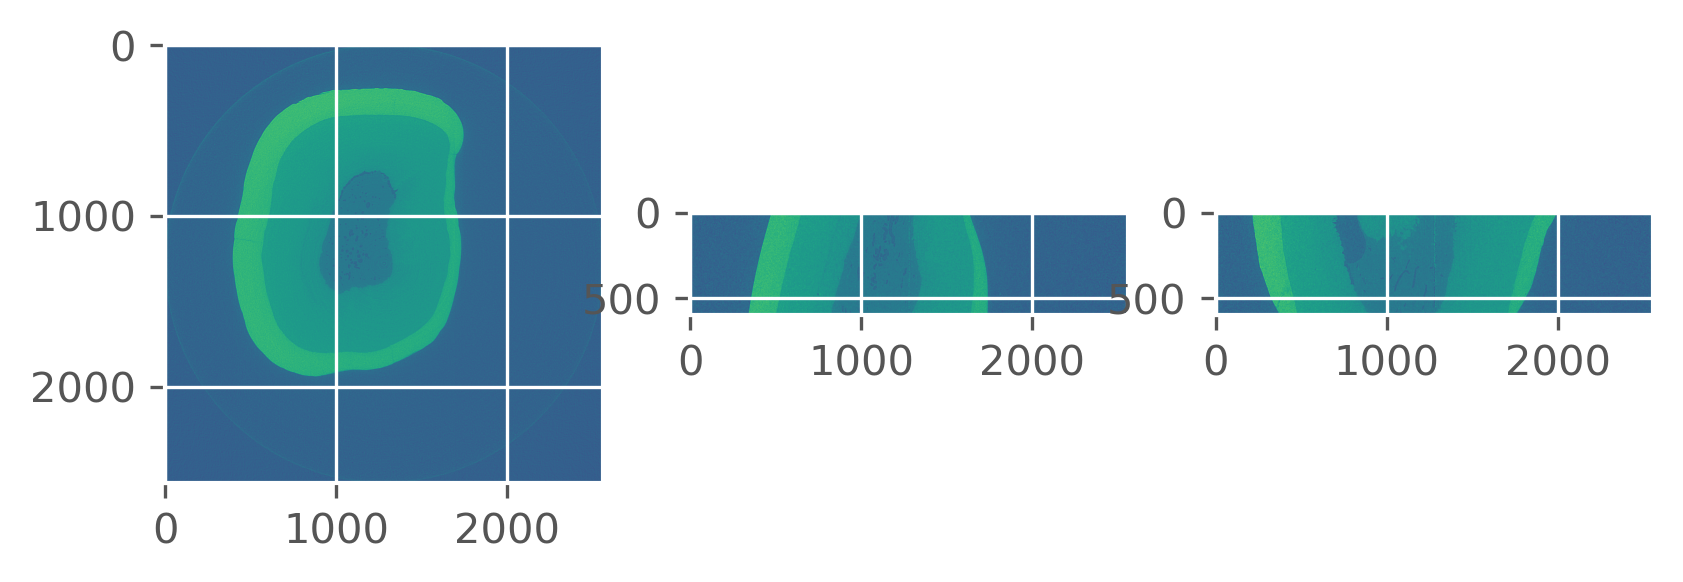

In [153]:
ru.plot_midplanes(recon_uint8)

## Write recon dataset
### Write output tiff stack as `uint8`

In [154]:
fileout = recon_dir_8bit+'slice.tiff'
# fileout = '/home/beats/Data/tmp/slice.tiff'
dxchange.writer.write_tiff_stack(recon_uint8,
                                 fname=fileout,
                                 dtype='uint8',
                                 axis=0,
                                 digit=4,
                                 start=0,
                                 overwrite=True)

### Write output tiff stack as `float32`

In [131]:
fileout = recon_dir+'slice.tiff'
dxchange.writer.write_tiff_stack(recon, fname=fileout, axis=0, digit=4, start=0, overwrite=True)

#### Open virtual stack in ImageJ

In [137]:
os.system(Fiji_exe_stack + fileout + ' &')

0

OpenJDK 64-Bit Server VM warning: ignoring option PermSize=128m; support was removed in 8.0
OpenJDK 64-Bit Server VM warning: Using incremental CMS is deprecated and will likely be removed in a future release


[INFO] Detected existing ImageJ; passing arguments along
Importing .TIFF sequence:
/home/beats/Data/beats_lecture/sand/recon_8bit/slice.tiff
Done.
